# git2net analysis for the pandas repository

First we clone the repo

In [ ]:
import pygit2 as git2
import os
import shutil

git_repo_url = 'https://github.com/pandas-dev/pandas.git'
local_directory = '.'
git_repo_dir = 'repos/pandas4analysis'

if os.path.exists(git_repo_dir):
    shutil.rmtree(git_repo_dir)

repo = git2.clone_repository(git_repo_url, git_repo_dir) # Clones a non-bare repository

Then we create the database for it. We will try with max_modification=100, so that most commits are processed.

In [ ]:
import git2net

sqlite_db_file = 'databases/pandas.db'

# Remove database if exists
if os.path.exists(sqlite_db_file):
    os.remove(sqlite_db_file)

max_modifications = 100
    
git2net.mine_git_repo(git_repo_dir, sqlite_db_file, max_modifications=max_modifications)

Let's check the commits that had more than 100 files modified

In [4]:
git2net.mining_state_summary(git_repo_dir, sqlite_db_file)

  0%|          | 0/6 [00:00<?, ?it/s]

490 / 496 (98.79%) of commits were successfully mined.


100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


,hash,is_merge,modifications,author_name,author_email,author_date
0,c6062051483a44b9068c2c4203dc3eb2d1780156,False,193,Charles Truong,charles@doffy.net,2020-03-20 19:18:47
1,e5e82e79ab439b8306bf6097f9b7e21d4769b8d3,True,246,Charles T,charles@doffy.net,2020-03-20 19:20:59
2,86140d08a9c210259346d7d61af713e3a65651e1,True,247,Charles T,charles@doffy.net,2020-03-25 17:40:34
3,77359107e606b0d09c78c86b28dec5a31fb833a4,False,193,Charles Truong,charles@doffy.net,2020-08-04 17:29:26
4,a403c5a84e8632bb061c5ce6806bc45bca33cdd5,True,194,Charles T,charles@doffy.net,2020-08-04 17:34:11
5,373018430411fc20930f6dd175e7d37e0aa21395,True,152,Charles T,charles@doffy.net,2020-10-23 13:43:33


Now let's visualize the result

In [81]:
import pathpy as pp

t, node_info, edge_info = git2net.get_coediting_network(sqlite_db_file)
pp.Network.from_temporal_network(t)

which files were edited by the authors

In [8]:
t, node_info, edge_info = git2net.get_bipartite_network(sqlite_db_file)
n = pp.Network.from_temporal_network(t)

colour_map = {'author': '#73D2DE', 'file': '#2E5EAA'}
node_color = {node: colour_map[node_info['class'][node]] for node in n.nodes}
pp.visualisation.plot(n, node_color=node_color)

Co-authorship network

In [9]:
n, node_info, edge_info = git2net.get_coauthorship_network(sqlite_db_file)
n

The network is too complex because we consider the whole timeframe of the repository since its creation. Therefore we need to filter the time dimensin, and in order to do that we nee to find the first and last commit in the repo.

In [34]:
import sqlite3
import pandas as pd
from datetime import datetime

db = sqlite3.connect(sqlite_db_file)
max_date = datetime.strptime(pd.read_sql_query("SELECT max(committer_date) as max FROM commits", db)['max'].item(), '%Y-%m-%d %H:%M:%S')
min_date = datetime.strptime(pd.read_sql_query("SELECT min(committer_date) as min FROM commits", db)['min'].item(), '%Y-%m-%d %H:%M:%S')

print('Min date: ', min_date)
print('Max date: ', max_date)

Min date:  2015-12-16 11:16:18
Max date:  2021-03-06 15:28:23


In order not to select an 'empty' time period (relatively few commits, e.g. holiday season), it's also worth observing the number of commits over time.

<BarContainer object of 1908 artists>

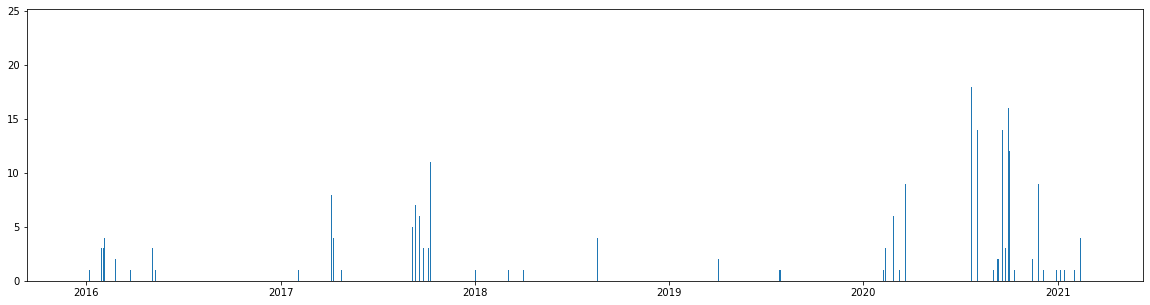

In [61]:
import pandas as pd
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt


pdCommits = pd.read_sql_query("SELECT * FROM commits", db)

days = {(min_date+timedelta(days=x)).date() : 0 for x in range((max_date-min_date).days + 1)}

commit_dates = pdCommits['committer_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date()).value_counts()

for key in commit_dates.keys():
    days[key] = commit_dates.get(key)

keys = days.keys()
values = days.values()
plt.figure(figsize=(20,5))
plt.bar(keys, values)

Let's choose the year 2020 based on the plot, as that was the busiest year.

In [82]:
time_from = datetime(2020, 1, 1)
time_to = datetime(2020, 12, 31)
n, node_info, edge_info = git2net.get_coauthorship_network(sqlite_db_file, time_from=time_from, time_to=time_to)
n

We can set the node size based on the number of degrees each author has in the network. This emphasizes who collaborate more with the others in the given timeframe.

In [139]:
node_style = zip(n.nodes, n.node_properties('degree'))
style = {}
style['node_size'] = {v:3+u for v,u in node_style}
pp.visualisation.plot(n, **style)

## Temporal network
Because our network changes over time, we would like to visualize each year consecutively one after the other. We can use the pathpy temporal networks for this. 

In [191]:
# help(pp.temporal_network)

t2 = pp.TemporalNetwork()
years = []

for year in range(min_date.year, max_date.year):
    print('Processing year: ', year)
    n, node_info, edge_info = git2net.get_coauthorship_network(sqlite_db_file, time_from=datetime(year, 1,1), time_to=datetime(year, 12, 31))
    years.append(n)
    for edge in list(n.edges.keys()):
        t2.add_edge(edge[0].replace(' ','_'),edge[1].replace(' ','_'),year)

# t2 = t.filter_edges(lambda v, w, time: True if (time_from <= time <= time_to) else False)

Processing year:  2015
Processing year:  2016
Processing year:  2017
Processing year:  2018
Processing year:  2019
Processing year:  2020


In [199]:
style = {    
  'ts_per_frame': 1, 
  'ms_per_frame': 2000,
  'look_ahead': 0, 
  'look_behind': 0, 
  'node_size': 15, 
  'inactive_edge_width': 2,
  'active_edge_width': 4, 
  'label_color' : '#000000',
  'label_size' : '8px',
  'label_offset': [0,5]
  }
print(t2)
pp.visualisation.plot(t2, **style, width=1000, height=1000)

Nodes:			12
Time-stamped links:	31
Links/Nodes:		2.5833333333333335
Observation period:	[2016, 2020]
Observation length:	 4 
Time stamps:		 4 
Avg. inter-event dt:	 1.3333333333333333
Min/Max inter-event dt:	 1/2
